## 1. Extract the zip file.


In [ ]:
import zipfile

with zipfile.ZipFile('/content/Copy of devnagari digit.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_file/')

## 1. Dataset Preparation and Preprocessing:


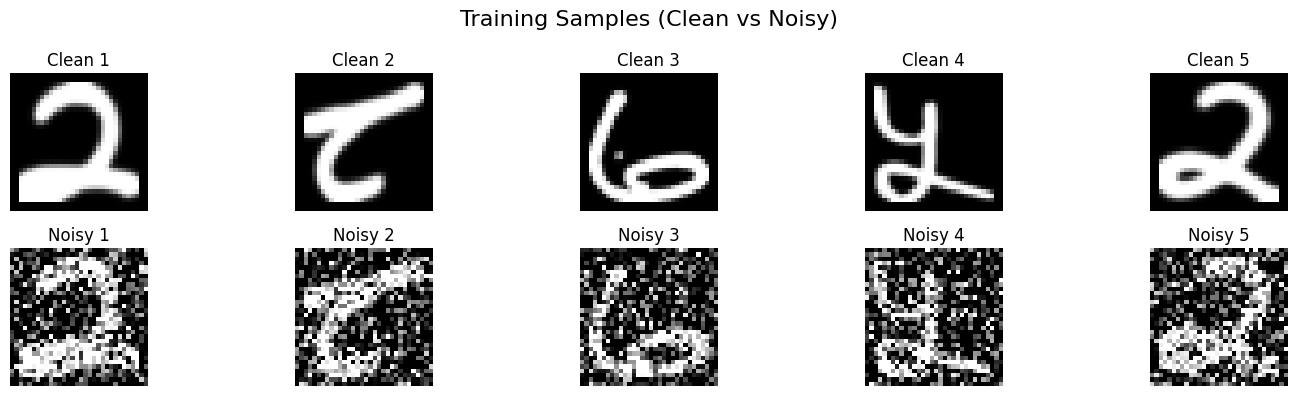

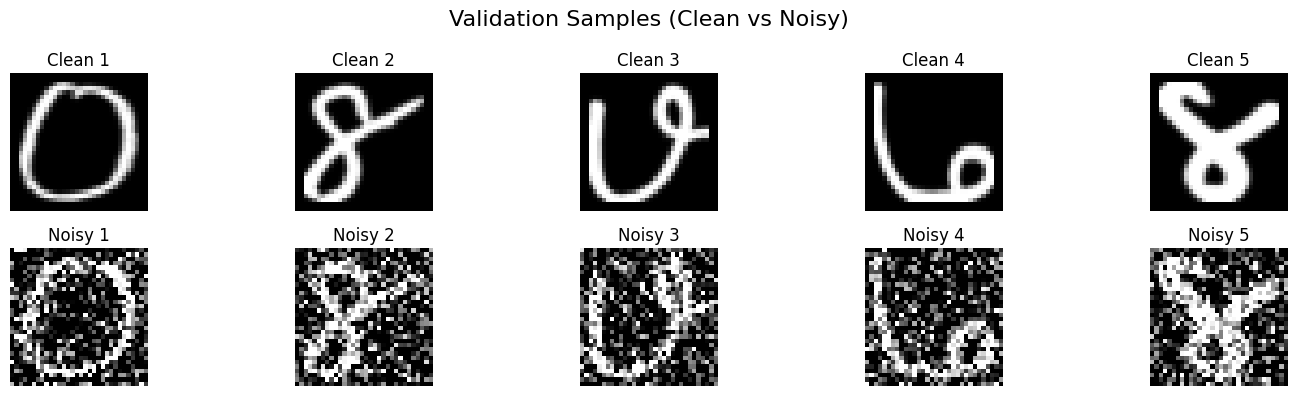

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split

# Load Devnagari dataset
def load_devnagari_dataset(data_path):
    images = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.png'):
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('L')  # Convert to grayscale
                img = img.resize((32, 32))  # Resize to 32x32
                images.append(np.array(img))
    return np.array(images)

# Load dataset (replace with your actual path)
data_path = '/content/extracted_file/DevanagariHandwrittenDigitDataset'
images = load_devnagari_dataset(data_path)

# Normalize images to [0, 1] range
images = images.astype('float32') / 255.

# Add channel dimension
images = np.expand_dims(images, axis=-1)

# Split into training and validation sets
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# Function to add Gaussian noise
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

# Add noise to training and validation sets
noise_factor = 0.5
x_train_noisy = add_noise(x_train, noise_factor)
x_test_noisy = add_noise(x_test, noise_factor)
x_train_noisy_high = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy_high = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)

# ========== VISUALIZATION ==========
def visualize_samples(clean, noisy, n_samples=5, title="Training Samples"):
    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16)

    for i in range(n_samples):
        # Original clean image
        plt.subplot(2, n_samples, i+1)
        plt.imshow(clean[i].squeeze(), cmap='gray')
        plt.title(f"Clean {i+1}")
        plt.axis('off')

        # Noisy version
        plt.subplot(2, n_samples, i+1+n_samples)
        plt.imshow(noisy[i].squeeze(), cmap='gray')
        plt.title(f"Noisy {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_samples(x_train, x_train_noisy, title="Training Samples (Clean vs Noisy)")

# Visualize validation samples
visualize_samples(x_test, x_test_noisy, title="Validation Samples (Clean vs Noisy)")


plt.tight_layout()
plt.show()

## 2. Build and training the Denoising Convolutional Autoencoder:

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
def build_deep_autoencoder(input_shape=(32, 32, 1)):
    # Encoder
    input_img = Input(shape=input_shape)

    # First convolutional layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Second convolutional layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    # First deconvolutional layer
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    # Third deconvolutional layer
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    # Final layer
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create and compile the autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

    return autoencoder

autoencoder = build_deep_autoencoder()
autoencoder.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.4377 - val_loss: 0.1816
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1783 - val_loss: 0.1679
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1673 - val_loss: 0.1633
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1633 - val_loss: 0.1590
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1596 - val_loss: 0.1566
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1577 - val_loss: 0.1548
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1554 - val_loss: 0.1532
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1543 - val_loss: 0.1521
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1524 - val_loss: 0.1519
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1514 - val_loss: 0.1503
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1507 - val_loss: 0.1494
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

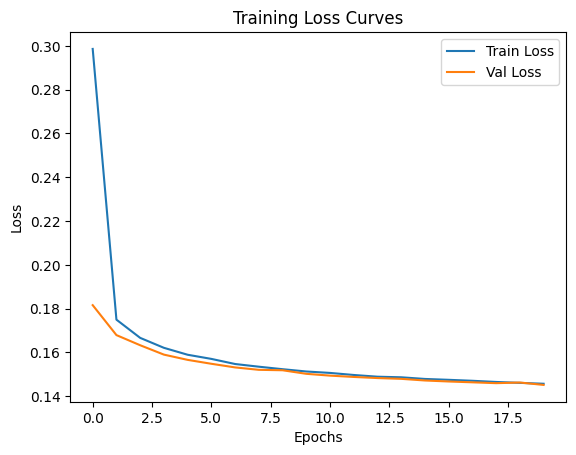

In [ ]:
# Build and train the autoencoder
autoencoder = build_deep_autoencoder()  # Call the correct function name
autoencoder.summary()

# Train with noisy input and clean target
history = autoencoder.fit(
    x_train_noisy_high, x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy_high, x_test)
)
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


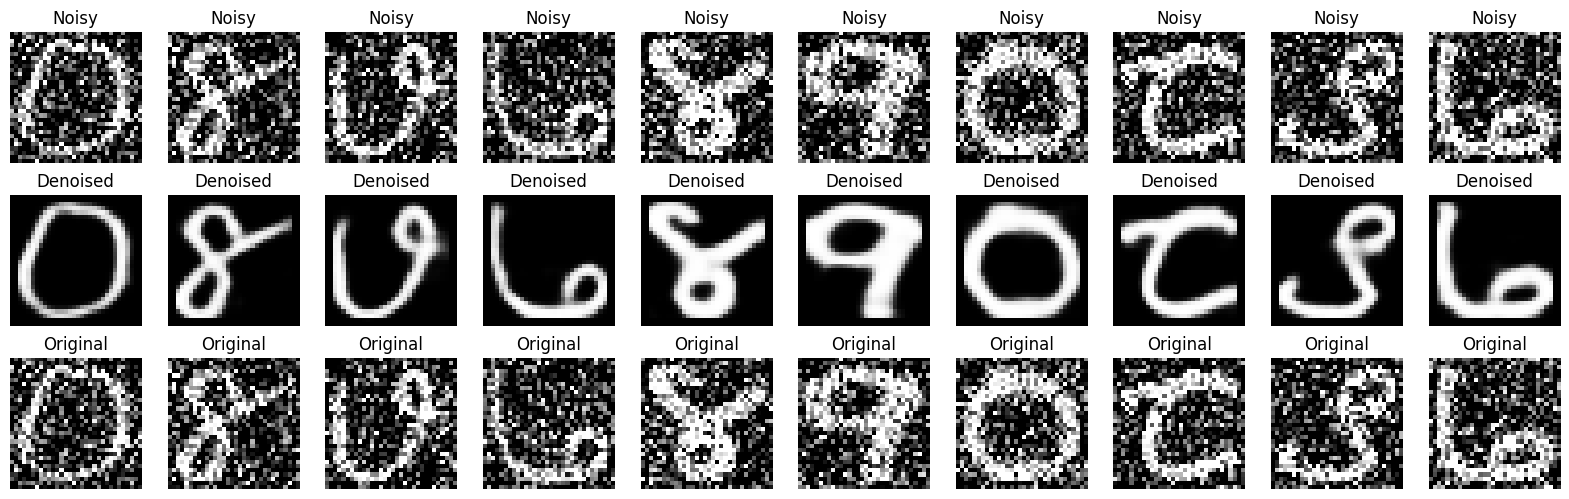

In [ ]:
# Predict on validation set
decoded_imgs = autoencoder.predict(x_test_noisy_high)

# Visualize noisy vs denoised vs original
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy_high[i].reshape(32, 32), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Denoised
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    # Original
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_noisy_high[i].reshape(32, 32), cmap='gray')
    plt.title("Original")
    plt.axis('off')
plt.show()